# Equatorial Pacific thermal bias and SST bias across ACCESS-OM2 Suite
Plots include Equatorial Pacific longitude-depth temperature bias and SST bias. A particular focus is the impact of the background diffusivity on the equatorial thermocline.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
session = cc.database.create_session('/home/561/rmh561/access-om2/cc_database.db')

In [4]:
# Define experiment dictionary
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degIAF',   {'model':'ACCESS-OM2 IAF', 'expt':'1deg_jra55v13_iaf_spinup1_B1', # 1deg IAF run from Kiss et al. 2020
                'n_files':-12, 'itime':pd.datetime(1998,1,1), 'ftime':None}),
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55v13_iaf_gmredi6', # 025deg IAF run from Kiss et al. 2020
                'n_files':-34, 'itime':pd.datetime(1998,1,1),'ftime':None}),
    ('01degIAF',  {'model':'ACCESS-OM2-01 IAF',  'expt':'01deg_jra55v13_iaf', # 01deg IAF run from Kiss et al. 2020
                'n_files':None, 'itime':pd.datetime(1998,1,1),'ftime':None}),
    ('1degRYF',   {'model':'ACCESS-OM2 RYF', 'expt':'1deg_jra55_ryf9091_gadi', # 1deg 9091RYF run
                'n_files':-1, 'itime': None,'ftime':None}),
    ('01degRYF',  {'model':'ACCESS-OM2-01 RYF',  'expt':'01deg_jra55v13_ryf9091', # 01deg 9091RYF run
                'n_files':None, 'itime': '2066-01-01','ftime': '2068-01-01'}),
    ('01degRYF_0Kv',  {'model':'ACCESS-OM2-01 RYF 0Kv',  'expt':'01deg_jra55v13_ryf9091_0Kv', # 01deg 9091RYF run with no Kback
                'n_files':None, 'itime': '2064-01-01','ftime': '2066-01-01'}),
    ('01degRYF_5Kv',  {'model':'ACCESS-OM2-01 RYF 5e-6Kv',  'expt':'01deg_jra55v13_ryf9091_5Kv', # 01deg 9091RYF run with 5e-6 Kback
                'n_files':None, 'itime': '2066-01-01','ftime': '2068-01-01'}),
    ('025degRYF_1Kv', {'model':'ACCESS-OM2-025 RYF 1e-6Kv', 'expt':'025deg_jra55_ryf_1Kv', # 025deg 9091RYF run 1e-6Kv
                'n_files':-5, 'itime': '2311-01-01','ftime': '2312-01-01'}),
    ('025degRYF', {'model':'ACCESS-OM2-025 RYF', 'expt':'025deg_jra55_ryf9091_gadi', # 025deg 9091RYF run
                'n_files':None, 'itime': '2311-01-01','ftime': '2312-01-01'})
])

In [5]:
# Add on pre-interpolated WOA13 directories for every run:
for ekey in exptdict.keys():
    e = exptdict[ekey]
    if (ekey.find('025deg') != -1):
        e['WOA13expt'] = '025_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom025.nc'
    elif (ekey.find('01deg') != -1):
        e['WOA13expt'] = '01'
        e['WOA13file'] = 'woa13_ts_??_mom01.nc'
    else:
        e['WOA13expt'] = '10_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom10.nc'

In [43]:
# Adjust times (without deleting all the data by rerunning the exptdict cell above!!!)
exptdict['01degRYF']['itime'] = '2062-01-01'
exptdict['01degRYF_0Kv']['itime'] = '2062-01-01'
exptdict['01degRYF_5Kv']['itime'] = '2062-01-01'
exptdict['01degRYF']['ftime'] = '2063-01-01'
exptdict['01degRYF_0Kv']['ftime'] = '2063-01-01'
exptdict['01degRYF_5Kv']['ftime'] = '2063-01-01'

In [6]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:38600 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [7]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## Biases from MOM-SIS CORE-NYF runs
see https://github.com/COSIMA/access-om2/issues/134
![title](MOM-SIS_bias.png)

## Equatorial Pacific longitude-depth biases:

In [8]:
# Get Equatorial Slice:
#ekeys = exptdict.keys()#['1degIAF','025degIAF','01degIAF']
#ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv','025degRYF_1Kv']#,'025degRYF']
#ekeys = ['025degRYF_1Kv']
#ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv']
ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv','025degRYF','025degRYF_1Kv']
for ekey in ekeys:
    e = exptdict[ekey]
    eq_temp = cc.querying.getvar(e['expt'], 'temp',session,
                chunks={'st_ocean': None}, n=e['n_files'],ncfile='ocean.nc',
                 start_time=e['itime'],end_time=e['ftime']).sel(yt_ocean=0,method='nearest')
    eq_temp = eq_temp.sel(time=slice(e['itime'],e['ftime']))
    e['yearrange'] = str(eq_temp.time.values[0])[0:7]+' to '+str(eq_temp.time.values[-1])[0:7]
    print(ekey+': '+e['yearrange'])
    e['eq_temp_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp',session).sel(GRID_Y_T=0.,method='nearest').mean('time')
    eq_temp_anom = eq_temp.mean('time') - 273.15 - e['eq_temp_WOA13'].values 
    e['eq_temp_anom'] = eq_temp_anom.load()

01degRYF: 2066-01 to 2067-12
01degRYF_0Kv: 2064-01 to 2065-12
01degRYF_5Kv: 2066-01 to 2067-12
025degRYF: 2311-01 to 2311-12
025degRYF_1Kv: 2311-01 to 2311-12


In [9]:
# Plot Equatorial Slices:
def plot_eq(ekeys):
    clev = np.arange(-3.,3.25,0.25)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)
        pn = e['eq_temp_anom'].plot.contourf(cmap='bwr',levels=clev,add_colorbar=False,yincrease=False)
        CS = e['eq_temp_WOA13'].plot.contour(levels=np.arange(0,32,2),colors='k')
        ax1.clabel(CS, inline=False,fmt='%d',fontsize=15)
        e['eq_temp_WOA13'].plot.contour(levels=[20.],colors='k',linewidths=3.)
        (e['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.],colors='k',linewidths=3.,linestyles='--')
        plt.title('('+chr(i+ord('a'))+') ' + e['model'] + ', ' + e['yearrange'])
        ax1.set_ylim([300.,0.])
        ax1.set_xlim([-220.,-80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        if i==0:
            ax1.text(-210.,275.,'WOA13 Isotherms',fontsize=15)
            p0=pn;

    ax5 = plt.axes([0.92,0.2,0.01,0.5])
    cb = plt.colorbar(p0,cax=ax5,orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

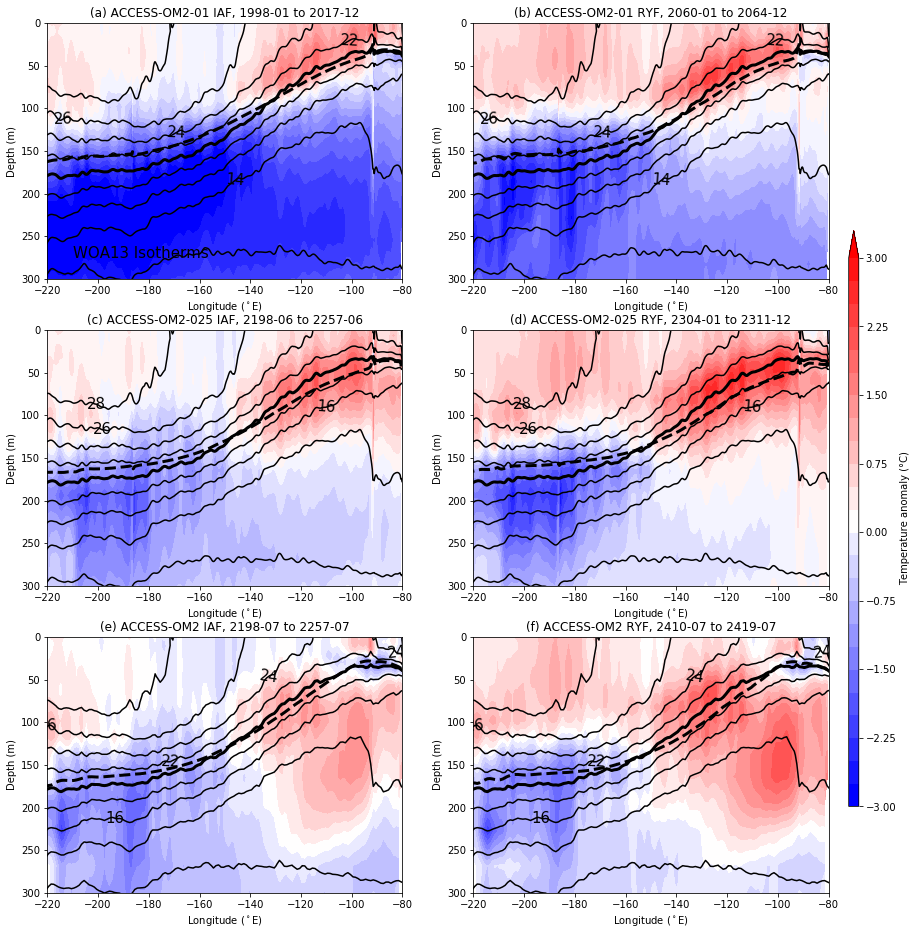

In [125]:
# Plot IAF and RYF runs at all resolutions:
fig = plt.figure(figsize=(14,16))
ekeys = ['01degIAF','01degRYF','025degIAF','025degRYF','1degIAF','1degRYF']
plot_eq(ekeys)
savefigure('eqpac_temp_bias_IAF_RYF')

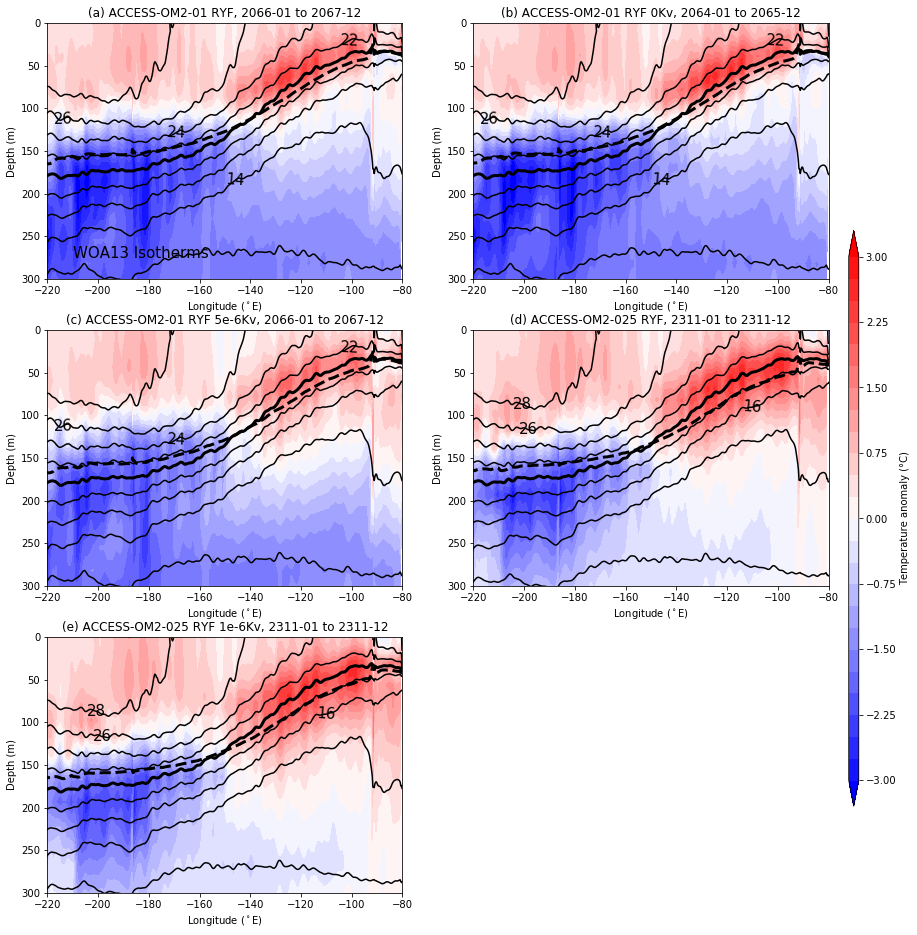

In [10]:
# Plot 1/10th and 1/4-degree background diffusivity runs:
fig = plt.figure(figsize=(14,16))
ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv','025degRYF','025degRYF_1Kv']
plot_eq(ekeys)
savefigure('eqpac_temp_bias_01deg_025degKv')

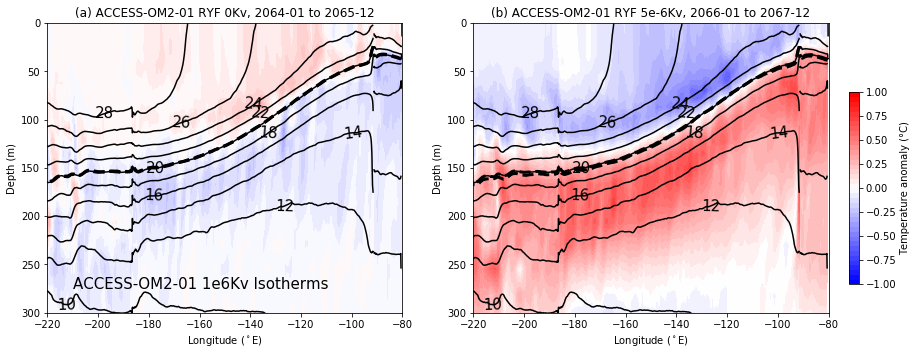

In [11]:
# Difference 10th-degree runs and plot (last two years respectively):
fig = plt.figure(figsize=(14,5.333))
clev = np.arange(-1.,1.05,0.05)
ekeys = ['01degRYF_0Kv','01degRYF_5Kv']
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)
    pn = (e['eq_temp_anom']-exptdict['01degRYF']['eq_temp_anom']).plot.contourf(cmap='bwr',levels=clev,add_colorbar=False,yincrease=False)
    CS = (exptdict['01degRYF']['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=np.arange(0,32,2),colors='k')
    ax1.clabel(CS, inline=False,fmt='%d',fontsize=15)
    (exptdict['01degRYF']['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.],colors='k',linewidths=3.,linestyles='--')
    (e['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.],colors='k',linewidths=3.,linestyles='--')
    plt.title('('+chr(i+ord('a'))+') ' + e['model'] + ', ' + e['yearrange'])
    ax1.set_ylim([300.,0.])
    ax1.set_xlim([-220.,-80.])
    ax1.set_ylabel('Depth (m)')
    ax1.set_xlabel('Longitude ($^\circ$E)')
    if i==0:
        ax1.text(-210.,275.,'ACCESS-OM2-01 1e6Kv Isotherms',fontsize=15)
        p0 = pn

ax5 = plt.axes([0.92,0.2,0.01,0.5])
cb = plt.colorbar(p0,cax=ax5,orientation='vertical')
cb.ax.set_ylabel('Temperature anomaly (°C)')

savefigure('eqpac_temp_bias_01degKv_difference')

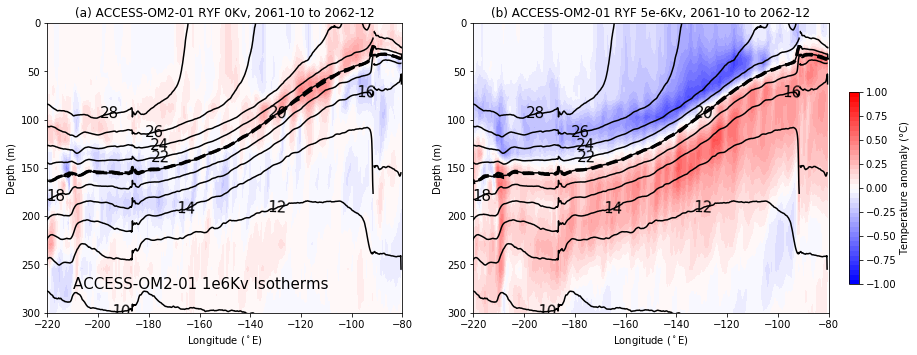

In [45]:
# Difference 10th-degree runs and plot (year 3):
fig = plt.figure(figsize=(14,5.333))
clev = np.arange(-1.,1.05,0.05)
ekeys = ['01degRYF_0Kv','01degRYF_5Kv']
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)
    pn = (e['eq_temp_anom']-exptdict['01degRYF']['eq_temp_anom']).plot.contourf(cmap='bwr',levels=clev,add_colorbar=False,yincrease=False)
    CS = (exptdict['01degRYF']['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=np.arange(0,32,2),colors='k')
    ax1.clabel(CS, inline=False,fmt='%d',fontsize=15)
    (exptdict['01degRYF']['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.],colors='k',linewidths=3.,linestyles='--')
    (e['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.],colors='k',linewidths=3.,linestyles='--')
    plt.title('('+chr(i+ord('a'))+') ' + e['model'] + ', ' + e['yearrange'])
    ax1.set_ylim([300.,0.])
    ax1.set_xlim([-220.,-80.])
    ax1.set_ylabel('Depth (m)')
    ax1.set_xlabel('Longitude ($^\circ$E)')
    if i==0:
        ax1.text(-210.,275.,'ACCESS-OM2-01 1e6Kv Isotherms',fontsize=15)
        p0 = pn

ax5 = plt.axes([0.92,0.2,0.01,0.5])
cb = plt.colorbar(p0,cax=ax5,orientation='vertical')
cb.ax.set_ylabel('Temperature anomaly (°C)')

savefigure('eqpac_temp_bias_01degKv_difference_year3')

## SST biases:

In [12]:
# Get SST:
ekeys = ['1degIAF','025degIAF','01degIAF','01degRYF','01degRYF_0Kv','01degRYF_5Kv','025degRYF','1degRYF']#,'025degRYF']
ekeys = ['1degRYF']#exptdict.keys()#['1degIAF','025degIAF','01degIAF']
ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv']#,'025degRYF','025degRYF_1Kv']
for ekey in ekeys:
    e = exptdict[ekey]
    surface_temp = cc.querying.getvar(e['expt'], 'temp',session,
                            chunks={'st_ocean': None}, n=e['n_files'],ncfile='ocean.nc',
                 start_time=e['itime'],end_time=e['ftime']).isel(st_ocean=0)
    surface_temp = surface_temp.sel(time=slice(e['itime'],e['ftime']))
    e['yearrange'] = str(surface_temp.time.values[0])[0:7]+' to '+str(surface_temp.time.values[-1])[0:7]
    print(ekey+': '+e['yearrange'])
    e['SST_WOA13'] = cc.querying.getvar(e['WOA13expt'], 'temp',session).isel(ZT=0).mean('time')
    SST_anom = surface_temp.mean('time') - 273.15 - e['SST_WOA13'].values 
    e['SST_anom'] = SST_anom.load()

01degRYF: 2066-01 to 2067-12
01degRYF_0Kv: 2064-01 to 2065-12
01degRYF_5Kv: 2066-01 to 2067-12


In [13]:
# Plot SST biases:
def plot_SST(ekeys):
    clev = np.arange(-3,3.25,0.25)
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='gray',linewidth=0.5)

    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(1+len(ekeys)//2,2,i+1,projection=ccrs.Robinson(central_longitude=-100))
        ax1.coastlines(resolution='50m')
        ax1.add_feature(land_50m)
        pn = e['SST_anom'].plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
        plt.title('('+chr(i+ord('a'))+') ' + e['model'] + ', ' + e['yearrange'])
        if i==1:
            p0=pn;

    i = i+1
    e = exptdict['01degRYF']
    ax1 = plt.subplot(1+len(ekeys)//2,2,i+1,projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    pn = e['SST_WOA13'].plot.contourf(cmap=cm.cm.thermal,levels=np.arange(-2.,32.,1.),add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') ' + 'WOA13')

    ax5 = plt.axes([0.92,0.52,0.01,0.33])
    cb = plt.colorbar(p0,cax=ax5,orientation='vertical')
    cb.ax.set_ylabel('SST anomaly (°C)')

    ax6 = plt.axes([0.92,0.13,0.01,0.33])
    cb = plt.colorbar(pn,cax=ax6,orientation='vertical')
    cb.ax.set_ylabel('SST (°C)')

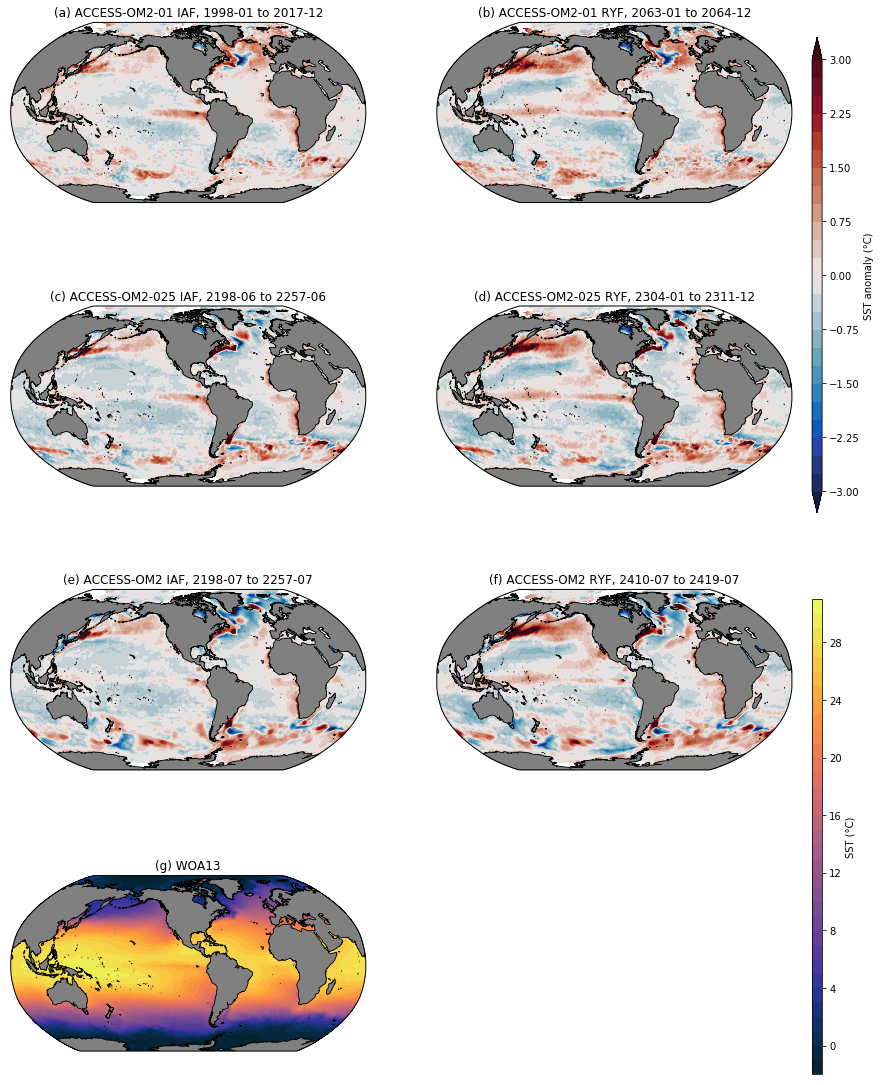

In [15]:
# Plot IAF and RYF runs at 3 resolutions:
fig = plt.figure(figsize=(14,20))
ekeys = ['01degIAF','01degRYF','025degIAF','025degRYF','1degIAF','1degRYF']
plot_SST(ekeys)
savefigure('SST_bias_IAF_RYF')

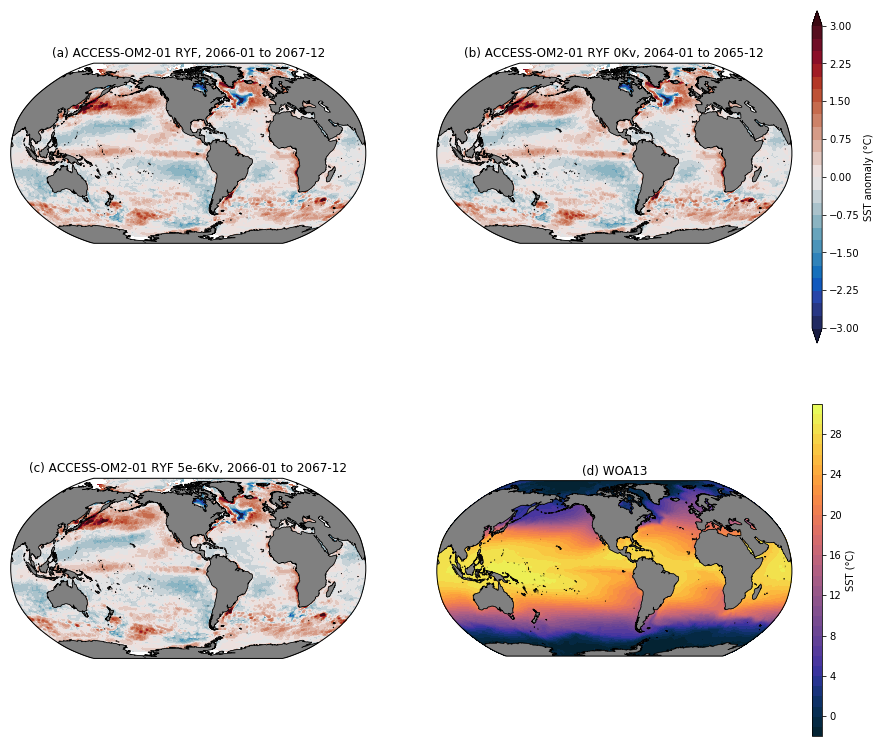

In [14]:
# Plot 1/10th degree background diffusivity runs:
fig = plt.figure(figsize=(14,14))
ekeys = ['01degRYF','01degRYF_0Kv','01degRYF_5Kv']
plot_SST(ekeys)
savefigure('SST_bias_01deg')

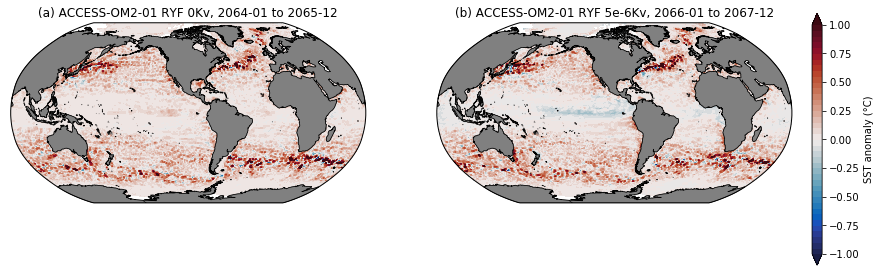

In [16]:
# Difference 1/10th-degree background diffusivity runs:
fig = plt.figure(figsize=(14,7))
ekeys = ['01degRYF_0Kv','01degRYF_5Kv']

clev = np.arange(-1,1.05,0.05)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)

for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1,projection=ccrs.Robinson(central_longitude=-100))
    ax1.coastlines(resolution='50m')
    ax1.add_feature(land_50m)
    surface_temp = cc.querying.getvar(e['expt'], 'temp',session,
                            chunks={'st_ocean': None}, n=e['n_files'],ncfile='ocean.nc',
                 start_time=e['itime'],end_time=e['ftime']).isel(st_ocean=0).sel(time=slice(e['itime'],e['ftime']))
    surface_temp_cntrl = cc.querying.getvar(exptdict['01degRYF']['expt'], 'temp',session,
                            chunks={'st_ocean': None}, n=exptdict['01degRYF']['n_files'],ncfile='ocean.nc',
                 start_time=exptdict['01degRYF']['itime'],end_time=exptdict['01degRYF']['ftime']).isel(st_ocean=0).sel(time=slice(exptdict['01degRYF']['itime'],exptdict['01degRYF']['ftime']))
    
    SST_anom = surface_temp.mean('time') - surface_temp_cntrl.mean('time') 
    SST_anom = SST_anom.load()
    pn = SST_anom.plot.contourf(cmap=cm.cm.balance,levels=clev,add_colorbar=False,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') ' + e['model'] + ', ' + e['yearrange'])
    if i==1:
        p0=pn;

ax5 = plt.axes([0.92,0.2,0.01,0.5])
cb = plt.colorbar(p0,cax=ax5,orientation='vertical')
cb.ax.set_ylabel('SST anomaly (°C)')

savefigure('SST_bias_01degKv_diff')